In [ ]:
# Here are some necessary packages that we need to import to run this notebook

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive 
drive.mount("/content/drive/")

import os
os.chdir("/content/drive/My Drive/DSECOP/Colab Notebooks/")
!pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/DSECOP/Colab Notebooks


# Curve fitting data to understand underlying trends

In this notebook, we'll learn how to *curve fit* a function to a histogram of a dataset. Finding a function that closely resembles a given histogram will provide information on the underlying model that governs the data.

## Why is curve fitting a histogram useful?



By binning a dataset into a histogram, we effectively reduce the dimension of the dataset from $N$ (the number of observables taken) to the number of bins that we choose for the histogram $I = \sum i$ (recall that in the last notebook, we introduced $i$ as an index over bins). Now, instead of trying to understand each observation made in isolation, we only have to understand $I$ more meaningful numbers that represent the probability distribution of the observations.

However, maybe we want to reduce the dimension of the dataset even further. Perhaps we only care about the mean value of the observables, or their standard deviation. Or, perhaps we're deciding between two theories that predict different analytic models that describe the distribution of observables, and we want to determine which analytic model is a better fit to the data. 

To do this, we'll need to *curve fit* our data.

---

Let's continue to analyze the Uranium-241 sample you were given. 

You know that radioactive decay processes can be modeled by Poisson processes. 

$$p_{\lambda}(n) = \frac{\lambda^n e^{-\lambda}}{n!} $$



**Activity:** Write a function that plots a Poisson distribution for a sample with 1000 counts. Plot it for a range of $\lambda$.

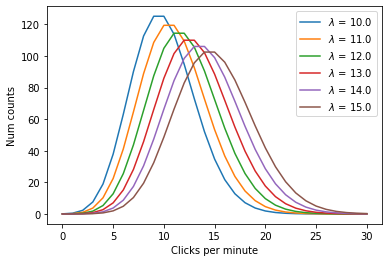

In [ ]:
n_vals = np.linspace(0, 30, 31)

def poisson(n, l, N):

  return [N*(l**x)*np.exp(-l) / np.math.factorial(x) for x in n]

plt.figure()
for l in np.linspace(10,15,6):
  plt.plot(n_vals, poisson(n_vals, l, 1000), label = "$\lambda$ = "+str(l))
plt.legend()

plt.xlabel("Clicks per minute")
plt.ylabel("Num counts")
plt.show()


## Curve fitting data determines model parameters



When we curve fit a function to a distribution of data, we need to first choosen an analytic model that we think could represent the underlying data. The curve fitting procedure then determines the exact values for the parameters of the model that best align with the data. 

Choosing the right analytic model can be a problem in its own right. The choice should be motivated by our theoretical understanding of the system. In the example of Uranium-241, we know that the counts per minute represents a decay process and can therefore be described by a Poisson distribution with a decasy rate $\lambda$. So there is one free parameter $\lambda$ that curve fitting will help determine. More generally, we might have to curve fit for a number of parameters $\Theta$. (For example, a simple gaussian curve already has 2 parameters, mean $\mu$ and standard deviation $\sigma$.)

In essense, these are the steps we want to execute:

1. Create a histogram for given dataset with a bin choice $b_i$. The histogram produces a list of counts in each bin, $n_i$.

2. Define a function $f(b_i, \Theta)$ to fit to the histogram. This function will be calculated at the center of each bin to produce a list of the same length of $n_i$.

3. Select a trial value for the fit parameter(s) $\Theta_{\textrm{trial}}$. Calculate the numbers $f(b_i, \Theta_{\textrm{trial}})$ at each bin center.

4. Calculate the *loss* between the fit function and the data, i.e. between $f(b_i, \Theta_{\textrm{trial}})$ and $n_i$. In some settings, this is also known as the *error* of the fit function.

4. Repeat steps 3 and 4 for a range of $\Theta_{\textrm{trial}}$ values. 

5. Select the $\Theta_{\textrm{trial}}$ that minimizes the loss. This will produce the best-fitting function to the data.

### How do we choose a loss function?



We haven't been very specific as to what the actual loss function is. In fact, many loss functions exist! The only requirements on loss functions are that they are small when the fit function closely matches the distribution of observables, and large otherwise.

Probably the most well-known loss function is the *mean-squared error*. 

$$\mathcal{L}_{MSE}(\Theta) = \frac{\sum_i (n_i - f(b_i, \Theta))^2}{\textrm{num. bins}}.$$

Remember that $n_i$ is the list of counts in each histogram bin, so it represents the data. $f(b_i, \Theta)$ is the model fit function at a given bin $b_i$. So if the fit function isn't a close match to the data, then we expect the error to be very large.

Another relatively common loss function is the *mean-absolute error*

$$\mathcal{L}_{MAE}(\Theta) = \frac{\sum_i |n_i - f(b_i, \Theta)|}{\textrm{num. bins}}.$$

This function might be preferred over the mean-squared error when you want to deemphasize the importance of outliers in the dataset.

**Activity**: Write a function to calculate the least square loss given a set of histogrammed counts ```obs_vals``` and a set of fit values ```fit_vals```.

In [ ]:
def least_sq_loss(obs_vals, fit_vals):

  loss = 0

  for i in range(len(obs_vals)):
    loss += (obs_vals[i] - fit_vals[i])**2

  return loss / len(obs_vals)

**Activity**: Read in the dataset ```geiger_counts_A.txt``` and histogram it. Calculate the loss between the histogram and a Poisson distribution for a range of trial $\lambda$'s, and find the lambda that minimizes the loss. Also provide a plot of the loss as a function of the parameter $\lambda$.

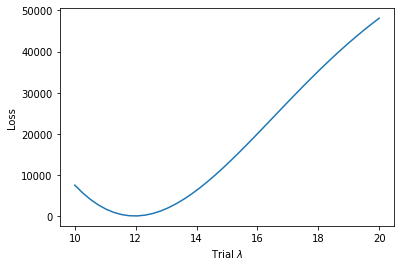

Value of $\lambda$ that minimizes the loss: 12.051282051282051


In [ ]:
# First histogram the data

dataset_location = "datasets/geiger_counts_A.txt"

def read_in_dataset(file_loc):

  with open(file_loc, "r") as infile:
    dataset = infile.read().split(",")
    num_clicks_per_minute = np.array([int(x) for x in dataset if x != " "])

    return num_clicks_per_minute

num_clicks_per_minute = read_in_dataset(dataset_location)
N = len(num_clicks_per_minute)

clicks_per_minute_bin_edges = np.linspace(-.5,30.5,32)
clicks_per_minute_bin_centers = 0.5*(clicks_per_minute_bin_edges[1:]+clicks_per_minute_bin_edges[:-1])


  # We're using np.histogram() here as we don't necessarily need to see the plot of the histogram
n_i, bins = np.histogram(num_clicks_per_minute, bins = clicks_per_minute_bin_edges, density = False)
# Determine what values of the Poisson parameter $\lambda$ to trial
trial_lam_vals = np.linspace(10,20,40)
trial_losses = []

# For every trial value $\lambda$, calculate the loss between the observed data and the corresponding trial Poisson fit function
for trial_lam in trial_lam_vals:

  fit_vals = list(poisson(clicks_per_minute_bin_centers, trial_lam, N))
  trial_loss = least_sq_loss(n_i, fit_vals)
  trial_losses.append(trial_loss)
  
#  Plot the losses as a function of the trial $\lambda$'s
plt.figure()
plt.plot(trial_lam_vals, trial_losses)
plt.xlabel("Trial $\lambda$")
plt.ylabel("Loss")
plt.show()

# Determine the $\lambda$ that minimizes the loss 
min_lambda = trial_lam_vals[np.where(trial_losses == np.min(trial_losses))][0]
print("Value of $\lambda$ that minimizes the loss:", min_lambda)


**Activity:** Now plot the best-fit Poisson function on top of a histogram of the data. Does the function provide a good fit to the data?

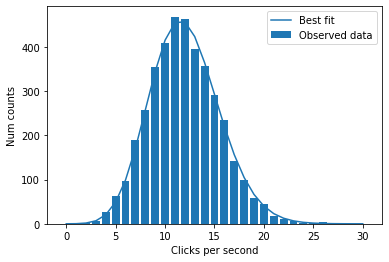

In [ ]:
plt.figure()
plt.bar(clicks_per_minute_bin_centers, n_i, label = "Observed data")
plt.plot(clicks_per_minute_bin_centers, poisson(clicks_per_minute_bin_centers, min_lambda, N), label = "Best fit")

plt.legend()

plt.xlabel("Clicks per minute")
plt.ylabel("Num counts")
plt.show()

### Using built-in functions to curve fit




As is the case with most common tasks, there are a number of curve fitting packages that are more efficient than anything we could write. One such package is ```scipy.optimize.curve_fit()```.

The function takes three main arguments: 

1. ```f```: the analytic function that you want to curve fit to. The function itself must be of the form ```f(data, params)``` (i.e. the first argument must be the observable)
2. ```xdata```: a ```np.array``` (or ```list```) containing the $x$-axis values that you want to include in the fit. This should be equal to the bin centers of your histogrammed data.
3. ```ydata```: a ```np.array``` (or ```list```) of the historam counts $n_i$

You can read more about ```scipy.optimize.curve_fit()``` [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).



**Activity:** Use ```scipy.optimize.curve_fit()``` to fit a Poisson distribution to the dataset. Then make a plot containing (1) a histogram of the dataset, (2) the best-fit Poisson function that you found from your manual scan over values of $\lambda$, and (3) the best-fit Poisson function returned by ```scipy.optimize()```.

[  11.9668975  3984.70830276]


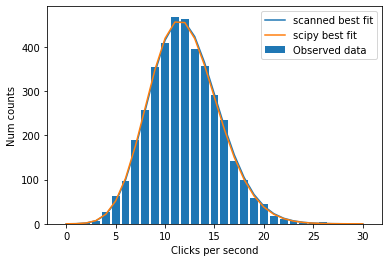

In [ ]:
from scipy.optimize import curve_fit


popt, pcov = curve_fit(poisson, clicks_per_minute_bin_centers, n_i)


plt.figure()
plt.bar(clicks_per_minute_bin_centers, n_i, label = "Observed data")
plt.plot(clicks_per_minute_bin_centers, poisson(clicks_per_minute_bin_centers, min_lambda, N) , label = "scanned best fit")
plt.plot(clicks_per_minute_bin_centers, poisson(clicks_per_minute_bin_centers, *popt), label = "scipy best fit")

plt.legend()

plt.xlabel("Clicks per minute")
plt.ylabel("Num counts")
plt.show()

## Stating fit model parameters with confidence

Now that we have found a value of $\lambda$ that minimizes the loss of our fit function, we are in a position to state our results. However, the results will be of limited use if we don't provide some sort of error on our estimate. 

Let's say that you ask a friend to independently measure the decay rate of your Uranium-241 sample so that you can compare estimates. The friend tells you that they've measured a decay rate of 12.6 counts / minute. This seems plausible, but it likely isn't exactly the decay rate that you measured. So there seems to be a conflict between the two measurements...

But wait! Your friend then tells you that the uncertainty on their measurement was 0.4 counts / minute. Does this fix the discrepancy?



### Where do uncertainties on a measurement come from?

In any physical experiment, there are many reasons why your measurement of a given quantity might not match the true quantity. 

There will certainly be **statistical errors**, which come from random fluctuations in nature. Just because we know that the decays per minute of a Uranium-241 sample are modeled by a Poisson distribution doesn't mean that we expect our measurements of the decays per minute to be *perfectly* Poissonian, just roughly so. Another random source of statistical errors can be the experimental setup: maybe when you set up the Uranium-241 sample every day, you use a ruler to put the sample exactly 10 cm from the Geiger counter. But perhaps on Monday, you actually put the sample 10.01 cm away, and on Tuesday you put the sample 9.95 cm away, and so on.

There might also be **systematic errors**, which come from the experimental setup. Maybe your Geiger counter is old and always beeps an extra two times a minute. Or perhaps your ruler isn't calibrated correctly, and what you read as 10 cm is in reality 10.1 cm.

As a result, when we make a measurement $Y$ for a given experiment, the distribution of all measurements $Y$ you could make, when accounting for all of the statistical and systematic errors of an experiment, follows a normal distribution.

<p><a href="https://sisu.ut.ee/measurement/31-normal-distribution">
<img src="https://drive.google.com/uc?export=view&id=1x5sxTgujQTaCPP4WlELtRJ8jiNxyGnNo" alt="drawing" width="400"/>
</a></p>

*Note*: that this distribution is not necessarily centered on the true value of the measurement $Y^*$! Imagine a scenario where your systematic errors all cause you to underestimate the measurement of $Y$. Systematic errors affect the *standard deviation* of the distribution. In contrast, statistical errors affect the *mean* of the distribution*.




### Converting measurement uncertainty to a stated measurement



The standard way to quote measurement uncertainty is to give the actual measured value $\pm$ 1 standard deviation of the uncertainty from all sources. So if a measurement is cited as 12.6 $\pm$ 0.4 counts / minute, this means that, given the observed evidence, there is a 68.3% chance that the true value of the decay rate lies between 12.2 and 13 counts per minute.

---

Where would these uncertainties come from? As a few examples: the uncertainty for experimental apparatuses would likely be given in the equiptment manuals. The uncertainty due to random fluctuations given bin in a histogram of counts is equal to the square root of the number of counts in that bin.

If you wanted to quote the measurement uncertainty using a model fitting tool like ```scipy.optimize.curve_fit()```, there is an easy way to do so. The function returns both ```popt``` (the best fit parameter values) and ```pcov```, which is a matrix quantifying the measurement uncertainties on these values. The square root of the diagonal entry in row $i$ corresponds to the fit uncertainty on parameter $i$.

**Activity**: State your recovered value of the decay rate $\lambda$, giving 80% and 95% uncertainty limits. Is your value for $\lambda$ consistent with your friend's?

In [ ]:
lambda_curve_fit = popt[0]
lambda_std = np.sqrt(np.diag(pcov))[0]

print("Recovered value of lambda is", lambda_curve_fit, "+/-", lambda_std)

Recovered value of lambda is 11.96689750165973 +/- 0.03540218199809753


*Move on to notebook 03*